<a href="https://colab.research.google.com/github/benduong2001/dsproject_font_decorator_bolditalic_unet/blob/main/font_bolditalic_unet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize
import pickle
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (7,7)

In [3]:
# example of training an conditional gan on the mnist dataset
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [5]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"

In [7]:
f = open(PATH_FOLDER+'unet_font_x_train_v2.pkl', 'rb') 
x_train = pickle.load(f)
f.close()     
f = open(PATH_FOLDER+'unet_font_y_train_v2.pkl', 'rb') 
y_train = pickle.load(f)
f.close()   
f = open(PATH_FOLDER+'unet_font_x_test_v2.pkl', 'rb') 
x_test = pickle.load(f)
f.close()   
f = open(PATH_FOLDER+'unet_font_y_test_v2.pkl', 'rb') 
y_test = pickle.load(f)
f.close()   

In [8]:
len(x_train), len(y_train),len(x_test),len(y_test)

(45572, 45572, 15164, 15164)

In [9]:
x_train[0].shape, y_train[0].shape, x_test[0].shape, y_test[0].shape, 

((20, 40, 1), (20, 40, 1), (20, 40, 1), (20, 40, 1))

In [10]:
x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
x_test = np.array(x_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [11]:
np.random.seed(1)
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train_ = x_train[randomize]
y_train_ = y_train[randomize]

In [12]:
def Conv_Dim_Preserved(x, n_filters):
    # preserve dimensiond: keep padding same, no stride
    # 1st round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)
    # 2nd round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

N_FILTERS = 32

inputs = Input((20, 40, 1))
x = inputs

# 20 by 20

c1 = Conv_Dim_Preserved(x, N_FILTERS*1)
print(c1.shape)
p1 = MaxPooling2D((2, 2), padding="same")(c1) # reduce dimensionality

# 10 by 10

c2 = Conv_Dim_Preserved(p1, N_FILTERS*2)
print(c2.shape)
p2 = MaxPooling2D((2, 2), padding="same")(c2) # reduce dimensionality

# 5 by 5

# Bottom of the unet "valley"
c3 = Conv_Dim_Preserved(p2, N_FILTERS*4)
# climb back up

u4 = Conv2DTranspose(N_FILTERS*2, (3, 3), strides = (2, 2), padding = 'same')(c3)
print(u4.shape, c2.shape)
u4 = Concatenate()([u4, c2])
#u4 = Dropout(0.1)(u4)
c4 = Conv_Dim_Preserved(u4, N_FILTERS*2)
# 10 x 10

u5 = Conv2DTranspose(N_FILTERS*1, (3, 3), strides = (2, 2), padding = 'same')(u4)
print(u5.shape, c1.shape)
u5 = Concatenate()([u5, c1])
#u5 = Dropout(0.1)(u5)
c5 = Conv_Dim_Preserved(u5, N_FILTERS*1)
# 10 x 10

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5) # CHANNEL IS 1
unet_model = Model(inputs=[inputs], outputs=[outputs])

unet_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

unet_model.summary()

(None, 20, 40, 32)
(None, 10, 20, 64)
(None, 10, 20, 64) (None, 10, 20, 64)
(None, 20, 40, 32) (None, 20, 40, 32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 40, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 20, 40, 32)   320         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 20, 40, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 40, 32)  128         ['activation[0

In [ ]:
history = unet_model.fit(x_train_, y_train_,epochs=5, batch_size=20)

In [ ]:
output_data = unet_model.predict(x_test, batch_size=512)

## **Evaluating Test Dataset** ##
* This section will look through random examples of the test dataset
* The original input image, then the model generation, then the actual target image, will be shown. 
* For display purposes, the encoding (that decide bold or italic) will be hidden.

In [266]:
def show_test_images(test_idx):
    # shows the images for the test set, with the x image, prediction image, and actual y image,
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 30))
    temp_x_test_img = np.squeeze((x_test[test_idx]*255).astype(int))
    temp_y_test_img = np.squeeze((y_test[test_idx]*255).astype(int))
    temp_pred_img = np.squeeze((output_data[test_idx]*255).astype(int))

    MAX_PIXEL_SHADE = 255
    if temp_x_test_img[:,20:].mean() == MAX_PIXEL_SHADE:
        effect = "Bold & Italic"
    elif temp_x_test_img[:,20:].mean() == 0:
        effect = "No Effect"
    else:
        if temp_x_test_img[:10,20:].mean() == MAX_PIXEL_SHADE:
            effect = "Italic"
        else:
            effect = "Bold"

    axes[0].imshow(MAX_PIXEL_SHADE-temp_x_test_img[:,:20], cmap="gray")
    axes[0].set_title("Input Image")
    axes[2].imshow(MAX_PIXEL_SHADE-temp_pred_img[:,:20], cmap="gray")
    axes[2].set_title("Model's Generated Output Image")
    axes[1].imshow(MAX_PIXEL_SHADE-temp_y_test_img[:,:20], cmap="gray")
    axes[1].set_title("Target Output Image\n Effect: {0}".format(effect))
    return axes


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf0cd05d0>,
      dtype=object)

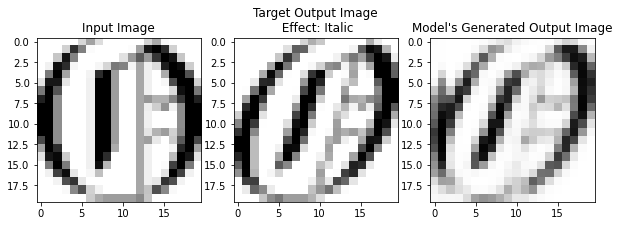

In [267]:
show_test_images(5998)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf0b61810>,
      dtype=object)

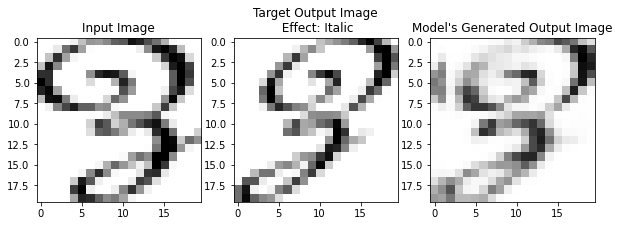

In [268]:

show_test_images(5437)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf0b75510>,
      dtype=object)

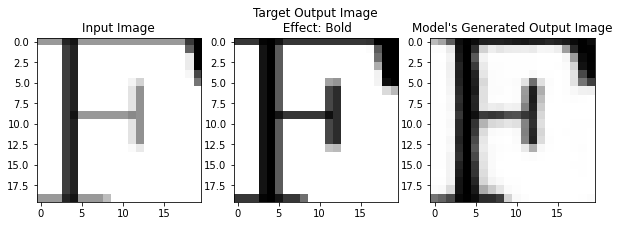

In [269]:
show_test_images(3443)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf0968950>,
      dtype=object)

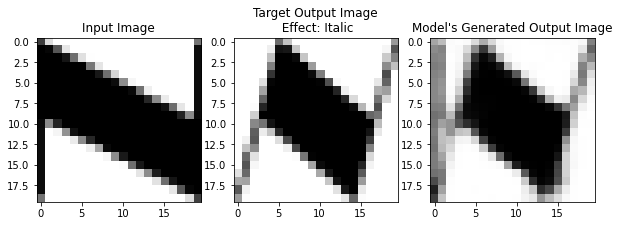

In [270]:
show_test_images(1800)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf082f610>,
      dtype=object)

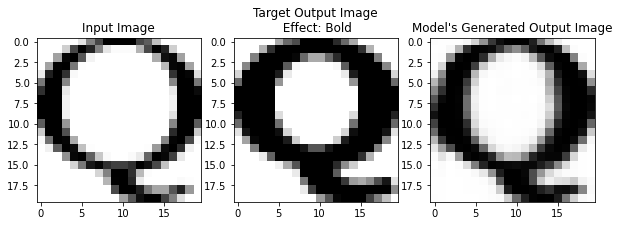

In [271]:
show_test_images(902)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddf070ccd0>,
      dtype=object)

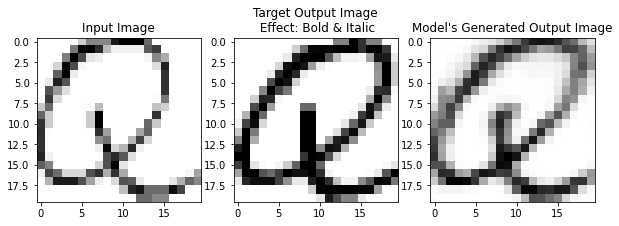

In [272]:
show_test_images(1421)

In [113]:
unet_model.save(PATH_FOLDER + "model_font_bolditalic_v2.h5")
saved_unet_model = tf.keras.models.load_model(PATH_FOLDER + "model_font_bolditalic_v2.h5")

## **User's Input** ##

* Now, you can create your own
* Include the input image png path. It must be a 20x20 picture with a handdrawn white character on a black background
* Include the character styling: bold, italic, both, neither
    * These can be done by adjusting the italic and bold arguments(between 0 and 1). These 2 options don't need to sum up to 1
    * For example, see what a 10% italic, 70% bold image would look like

In [285]:
def create_encoding(italic, bold):
    # channel_type is 1 for italic, 2 for bold, 3 for both
    assert italic >= 0 and italic <= 1
    assert bold >= 0 and bold <= 1

    DIM1 = 20
    DIM2 = 20
    channel = np.zeros((DIM1,DIM2)).astype(float)
    channel[:10,:] = italic
    channel[10:,:] = bold

    return channel

In [303]:
def show_generation_input(input_image, ITALIC,BOLD):
    # Image Pre-processing

    input_image_arr = np.array(input_image)
    input_image_arr = input_image_arr.astype(float)
    #MAX_PIXEL_SHADE = 255
    MAX_PIXEL_SHADE = input_image_arr.max()
    input_image_arr /= MAX_PIXEL_SHADE

    # Effect Encoding

    temp_encoding = create_encoding(ITALIC,BOLD).astype(float)
    input_image_arr_concat = np.hstack([input_image_arr,temp_encoding])
    # plt.imshow((input_image_arr_concat*255).astype(int))

    # Effect Generation

    model_input_image = np.array([np.expand_dims(input_image_arr_concat,2)]) # model_input_image.shape # x_test.shape
    output_generation = unet_model.predict(model_input_image)

    output_generation_image_array = np.squeeze((output_generation[0]*255).astype(int))

    output_generation_image = output_generation_image_array[:, :20]

    # shows the images for the test set, with the x image, prediction image
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

    axes[0].imshow(input_image_arr,cmap="gray")
    axes[0].set_title("Input Image")
    axes[1].imshow(output_generation_image,cmap="gray")
    axes[1].set_title("Model's Generated Output Image\nItalic={0}%, Bold={1}%".format(str(int(ITALIC*100)),str(int(BOLD*100))))

In [304]:
INPUT_IMAGE_FILE_NAME = "input_image.png" # must be 20x20 png, white text on black background
ITALIC_OPTION = 0.8
BOLD_OPTION = 0.1

In [305]:
PATH_INPUT_IMAGE = PATH_FOLDER + INPUT_IMAGE_FILE_NAME
input_image = Image.open(PATH_INPUT_IMAGE)

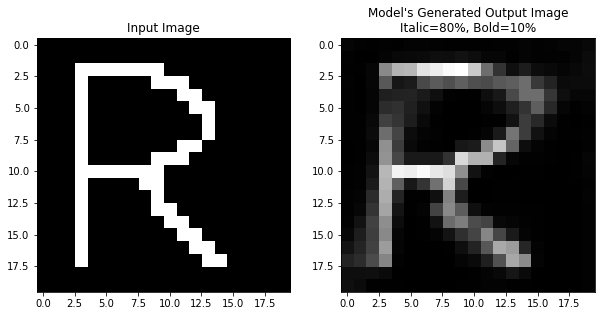

In [306]:
show_generation_input(input_image, ITALIC=ITALIC_OPTION, BOLD=BOLD_OPTION)

### **We can try out more options** ###

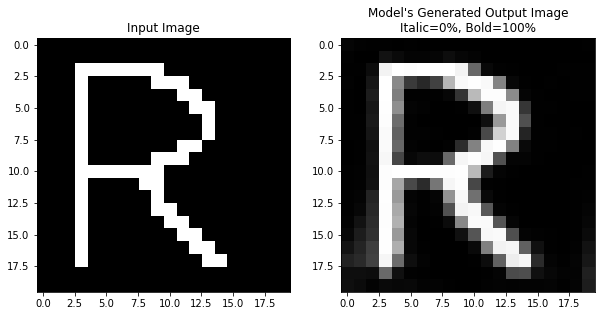

In [307]:
show_generation_input(input_image, ITALIC=0, BOLD=1)

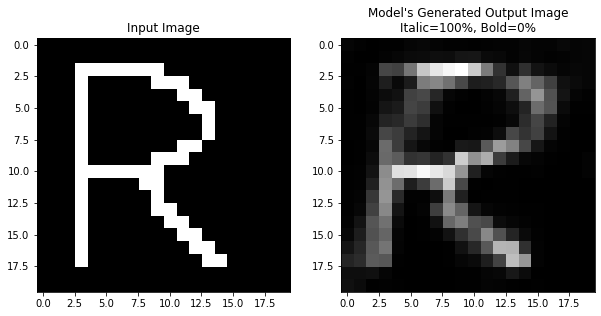

In [308]:
show_generation_input(input_image, ITALIC=1, BOLD=0)

### **The model seems to respond differently based on font-type** ###
* In typography, when a serif font gets bolded, usually every part of the letter gets thickened **except** the serif-parts.
* This input example is a hand-drawn serif letter R
* It seems like the model has in fact picked up on this typographic convention (aside from recognizing the font-type of the letter). More inspection will be needed to look into this.

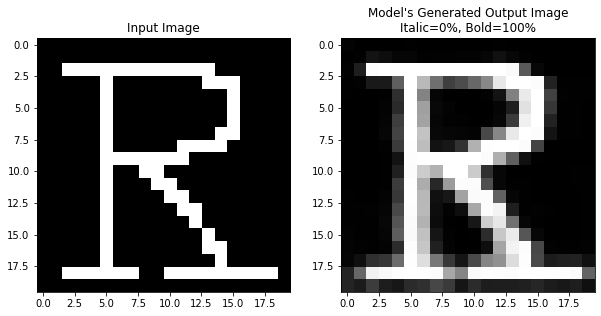

In [309]:
INPUT_IMAGE_FILE_NAME = "input_image2.png" # must be 20x20 png, white text on black background
PATH_INPUT_IMAGE = PATH_FOLDER + INPUT_IMAGE_FILE_NAME
input_image = Image.open(PATH_INPUT_IMAGE)
show_generation_input(input_image, ITALIC=0, BOLD=1)

### **How will it work with a smiley face?** ###
* The dataset only has the capital letters. How will it respond to a number, a lowercase letter, a question mark, or even a smiley face?

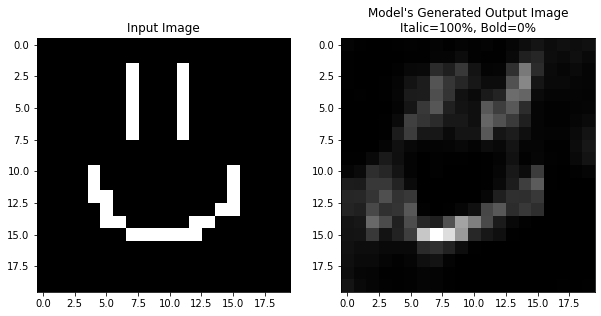

In [317]:
INPUT_IMAGE_FILE_NAME = "input_image3.png" # must be 20x20 png, white text on black background
PATH_INPUT_IMAGE = PATH_FOLDER + INPUT_IMAGE_FILE_NAME
input_image = Image.open(PATH_INPUT_IMAGE)
show_generation_input(input_image, ITALIC=1, BOLD=0)